In [1]:
import pandas as pd
import cassandra
import re
import os
import glob
import numpy as np
import json
import csv
import matplotlib.pyplot as plt
from cassandra.cluster import Cluster
import requests
from fuzzywuzzy import fuzz
from collections import defaultdict
from fuzzywuzzy import process
from nltk.tokenize import word_tokenize
from settrade_v2 import Investor
from pprint import pprint
from settrade_v2 import Investor
from datetime import datetime 

/opt/homebrew/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [5]:
cluster = Cluster(['127.0.0.1']) 
session = cluster.connect()

In [30]:
# สร้าง Keyspace หากยังไม่มี
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS stock_data 
    WITH replication = {'class': 'SimpleStrategy', 'replication_factor': 1}
""")

# ใช้ Keyspace ที่สร้างขึ้น
session.set_keyspace('stock_data')

print("Keyspace 'stock_data' ถูกสร้างและใช้งานเรียบร้อย!")

Keyspace 'stock_data' ถูกสร้างและใช้งานเรียบร้อย!


In [24]:
investor = Investor(
                    app_id="V5Qrec5DTtZhJBmb",
                    app_secret="APbRMnVb4qQlfeXuC/sflrq9I4xlWzA3Tcd8Fuz6NuAy",
                    broker_id="SANDBOX",
                    app_code="SANDBOX",
                    is_auto_queue = False)
                    

In [26]:
# กรณี Investor
market = investor.MarketData()


res = market.get_candlestick(
    symbol="BBL",
    interval="1d",
    limit=1,
    normalized=True,
)

print(res)

{'lastSequence': 0, 'time': [1742144400], 'open': [146.0], 'high': [147.0], 'low': [144.5], 'close': [144.5], 'volume': [9769807], 'value': [1418735868.5]}


In [27]:
print(res)
print(type(res))

{'lastSequence': 0, 'time': [1742144400], 'open': [146.0], 'high': [147.0], 'low': [144.5], 'close': [144.5], 'volume': [9769807], 'value': [1418735868.5]}
<class 'dict'>


In [31]:
# 👉 เชื่อมต่อ Cassandra
cluster = Cluster(['127.0.0.1'])  # Localhost
session = cluster.connect()

# 👉 เลือกใช้ Keyspace
session.set_keyspace('stock_data')

# 👉 ตรวจสอบและสร้างตาราง (ถ้ายังไม่มี)
session.execute("""
    CREATE TABLE IF NOT EXISTS candlestick_data (
        symbol TEXT,
        time TIMESTAMP PRIMARY KEY,
        open_price FLOAT,
        high_price FLOAT,
        low_price FLOAT,
        close_price FLOAT,
        volume INT,
        value FLOAT
    )
""")
print("✅ Keyspace และ Table พร้อมใช้งาน!")

# 👉 ฟังก์ชันดึงข้อมูลหุ้น
def fetch_and_store_stock(symbol="BBL", interval="1d", limit=10):
    res = market.get_candlestick(symbol=symbol, interval=interval, limit=limit, normalized=True)

    if not res:
        print(f"⚠️ ไม่พบข้อมูลสำหรับ {symbol}")
        return

    for i in range(len(res["time"])):
        timestamp = datetime.fromtimestamp(res["time"][i])  
        open_price = res["open"][i]
        high_price = res["high"][i]
        low_price = res["low"][i]
        close_price = res["close"][i]
        volume = res["volume"][i]
        value = res["value"][i]

        session.execute("""
            INSERT INTO candlestick_data (symbol, time, open_price, high_price, low_price, close_price, volume, value)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
        """, (symbol, timestamp, open_price, high_price, low_price, close_price, volume, value))

    print(f"✅ เพิ่มข้อมูล {len(res['time'])} รายการของหุ้น {symbol} สำเร็จ!")

# 👉 ทดสอบดึงข้อมูลหุ้น BBL
fetch_and_store_stock(symbol="BBL", interval="1d", limit=10)


✅ Keyspace และ Table พร้อมใช้งาน!
✅ เพิ่มข้อมูล 10 รายการของหุ้น BBL สำเร็จ!


In [32]:
from cassandra.cluster import Cluster

# 👉 เชื่อมต่อ Cassandra
cluster = Cluster(['127.0.0.1'])  # ถ้าเป็น localhost
session = cluster.connect()

# 👉 เลือก Keyspace
session.set_keyspace('stock_data')

# 👉 ดึงรายชื่อตารางทั้งหมดใน Keyspace
rows = session.execute("SELECT table_name FROM system_schema.tables WHERE keyspace_name = 'stock_data'")

print("📌 ตารางที่อยู่ใน Keyspace 'stock_data':")
for row in rows:
    print("-", row.table_name)

# 👉 เช็คโครงสร้างของตาราง candlestick_data
table_info = session.execute("SELECT * FROM system_schema.columns WHERE keyspace_name = 'stock_data' AND table_name = 'candlestick_data'")

print("\n📌 โครงสร้างของตาราง 'candlestick_data':")
for column in table_info:
    print("-", column.column_name, column.type)

📌 ตารางที่อยู่ใน Keyspace 'stock_data':
- candlestick_data

📌 โครงสร้างของตาราง 'candlestick_data':
- close_price float
- high_price float
- low_price float
- open_price float
- symbol text
- time timestamp
- value float
- volume int


In [34]:
import pandas as pd
import time

# ✅ โหลดรายชื่อหุ้นทั้งหมดจากไฟล์ CSV
try:
    symbols_df = pd.read_csv("thai_stocks-1.csv")  # ไฟล์ต้องมีคอลัมน์ 'symbol'
    symbols = symbols_df['symbol'].dropna().tolist()
except FileNotFoundError:
    print("❌ ไม่พบไฟล์ 'thai_stocks.csv' ใช้รายชื่อหุ้นที่กำหนดแทน")
    symbols = ["PTT", "AOT", "SCB", "CPALL", "ADVANC"]

# ✅ ฟังก์ชันที่ดึงข้อมูล Financial Data สำหรับหุ้นแต่ละตัว
def insert_financial_data(symbol):
    try:
        # 👉 ดึงข้อมูลจาก Settrade API หรือแหล่งข้อมูลอื่น ๆ
        res = market.get_candlestick(symbol=symbol, interval="1d", limit=10, normalized=True)

        if not res:
            print(f"⚠️ ไม่พบข้อมูลสำหรับ {symbol}")
            return

        # 👉 เชื่อมต่อ Cassandra (หรือฐานข้อมูลอื่น ๆ)
        from cassandra.cluster import Cluster
        cluster = Cluster(['127.0.0.1'])  # ถ้าเป็น localhost
        session = cluster.connect()
        session.set_keyspace('stock_data')

        # 👉 วนลูปเก็บข้อมูล
        for i in range(len(res["time"])):
            timestamp = datetime.fromtimestamp(res["time"][i])  
            open_price = res["open"][i]
            high_price = res["high"][i]
            low_price = res["low"][i]
            close_price = res["close"][i]
            volume = res["volume"][i]
            value = res["value"][i]

            # 👉 แทรกข้อมูลลงในตาราง
            session.execute("""
                INSERT INTO candlestick_data (symbol, time, open_price, high_price, low_price, close_price, volume, value)
                VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
            """, (symbol, timestamp, open_price, high_price, low_price, close_price, volume, value))

        print(f"✅ เพิ่มข้อมูล {len(res['time'])} รายการของหุ้น {symbol} สำเร็จ!")

    except Exception as e:
        print(f"❌ เกิดข้อผิดพลาดในการดึงข้อมูลของหุ้น {symbol}: {e}")

# ✅ ดึงข้อมูล Financial Data สำหรับหุ้นทุกตัว
for symbol in symbols:
    insert_financial_data(symbol)
    time.sleep(2)  # ⏳ ควบคุม API Rate Limit

✅ เพิ่มข้อมูล 10 รายการของหุ้น 24CS สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น 2S สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น 3BBIF สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น A สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น A5 สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น AAI สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น AAV สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น ABM สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น ACAP สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น ACC สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น ACE สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น ACG สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น ADB สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น ADD สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น ADVANC สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น ADVICE สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น AE สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น AEONTS สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น AF สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น AFC สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น AGE สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น AH สำเร็จ!
✅ เพิ่มข้อมูล 10 รายการของหุ้น AHC สำเร็จ!
✅ เพิ

In [6]:
from cassandra.cluster import Cluster
import pandas as pd

# เชื่อมต่อกับ Cassandra
cluster = Cluster(['127.0.0.1'])  # ระบุ IP ของ Cassandra node ที่คุณใช้งาน
session = cluster.connect('stock_data')  # เปลี่ยนเป็น keyspace ของคุณ

# สั่งเลือกข้อมูลจากตาราง candlestick_data
symbol = "SAM"
query = f"SELECT time, open_price, high_price, low_price, close_price FROM candlestick_data WHERE symbol = '{symbol}' ALLOW FILTERING;"

# ดึงข้อมูลจาก Cassandra
rows = session.execute(query)

# สร้าง DataFrame จากผลลัพธ์
data = []
for row in rows:
    data.append({
        "time": row.time,
        "open_price": row.open_price,
        "high_price": row.high_price,
        "low_price": row.low_price,
        "close_price": row.close_price
    })

df = pd.DataFrame(data)

# แสดง DataFrame
print(df)

        time  open_price  high_price  low_price  close_price
0 2025-02-20        0.17        0.18       0.16         0.18
1 2025-02-14        0.16        0.16       0.15         0.16
2 2025-02-19        0.16        0.18       0.16         0.17
3 2025-02-17        0.15        0.16       0.15         0.16
4 2025-02-21        0.17        0.18       0.17         0.17
5 2025-02-18        0.15        0.17       0.15         0.16


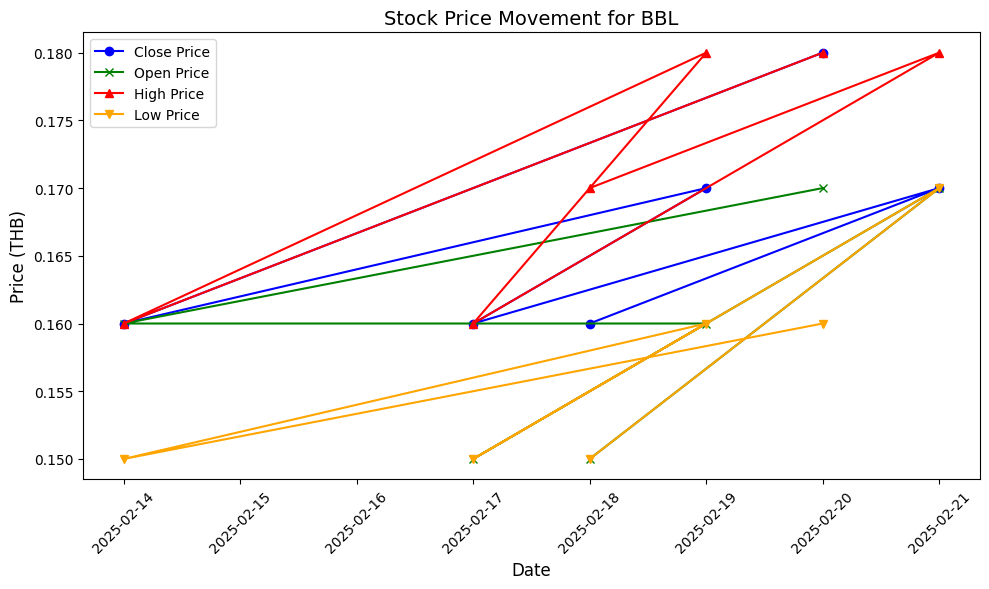

In [7]:
from cassandra.cluster import Cluster
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


# Plotting the stock data using Matplotlib
plt.figure(figsize=(10, 6))

# Plot Close Price
plt.plot(df['time'], df['close_price'], label="Close Price", color='blue', marker='o')

# Plot Open Price
plt.plot(df['time'], df['open_price'], label="Open Price", color='green', marker='x')

# Plot High Price
plt.plot(df['time'], df['high_price'], label="High Price", color='red', marker='^')

# Plot Low Price
plt.plot(df['time'], df['low_price'], label="Low Price", color='orange', marker='v')

# Adding labels and title
plt.title('Stock Price Movement for BBL', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (THB)', fontsize=12)
plt.legend(loc='best')

# Formatting the x-axis to show dates properly
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()